## Applied Data Science Capstone Project — Strategic Clustering for Establishing a Cafe in Hong Kong

### Import Necessary Libraries

In [7]:
!pip install beautifulsoup4
!pip install requests
!pip install lxml

from bs4 import BeautifulSoup
import requests
import pandas as pd
import lxml.html as lh

### Load Data

In [8]:
#List of districts with latitude and longitude
xy_path = pd.read_csv('District_HK.csv')
df_xy = pd.DataFrame(xy_path)
df_xy.head()

,ObjectID,District,Latitude,Longitude
0,1,Central And Western,22.28674,114.15488
1,2,Eastern,22.28418,114.22429
2,3,Southern,22.24734,114.15916
3,4,Wan Chai,22.27726,114.17283
4,5,Sham Shui Po,22.33191,114.16041


In [9]:
#List of districts with population
po_path = pd.read_csv('Population.csv')
df_po = pd.DataFrame(po_path)
df_po.head()

,District,Population
0,Central and Western,243266
1,Eastern,555034
2,Southern,274994
3,Wan Chai,180123
4,Sham Shui Po,405869


In [18]:
#List of districts with median monthly household income
hi_path = pd.read_csv('Household_income.csv')
df_hi = pd.DataFrame(hi_path)
df_hi.head()

,District,Median monthly\r\nhousehold income (HK$)
0,Central And Western,41400
1,Eastern,34300
2,Southern,32800
3,Wan Chai,44100
4,Sham Shui Po,24300


### Merging Dataframes

In [19]:
from functools import reduce
dfs = [df_xy, df_po, df_hi]
df_all = reduce(lambda left,right: pd.merge(left,right,on='District', how='outer'), dfs)
df_all

,ObjectID,District,Latitude,Longitude,Population,Median monthly\r\nhousehold income (HK$)
0,1.0,Central And Western,22.28674,114.15488,NaN,41400.0
1,2.0,Eastern,22.28418,114.22429,555034.0,34300.0
2,3.0,Southern,22.24734,114.15916,274994.0,32800.0
3,4.0,Wan Chai,22.27726,114.17283,180123.0,44100.0
4,5.0,Sham Shui Po,22.33191,114.16041,405869.0,24300.0
5,6.0,Kowloon City,22.31195,114.18965,418732.0,30000.0
6,7.0,Kwun Tong,22.31330,114.22201,648541.0,22500.0
7,8.0,Wong Tai Sin,22.34194,114.19208,425235.0,25500.0
8,9.0,Yau Tsim Mong,22.32149,114.17262,342970.0,30000.0
9,10.0,Islands,22.28674,114.15487,156801.0,28400.0


In [20]:
df_all.rename(columns={'Median monthly\r\nhousehold income (HK$)':'Median monthly household income (HK$)'}, inplace=True)
df_all.at[0, 'Population'] = 243266.0
df_all.dropna(how='any', inplace=True)
df_all[['ObjectID','Population']] = df_all[['ObjectID','Population']].astype("int")

df_all

,ObjectID,District,Latitude,Longitude,Population,Median monthly household income (HK$)
0,1,Central And Western,22.28674,114.15488,243266,41400.0
1,2,Eastern,22.28418,114.22429,555034,34300.0
2,3,Southern,22.24734,114.15916,274994,32800.0
3,4,Wan Chai,22.27726,114.17283,180123,44100.0
4,5,Sham Shui Po,22.33191,114.16041,405869,24300.0
5,6,Kowloon City,22.31195,114.18965,418732,30000.0
6,7,Kwun Tong,22.31330,114.22201,648541,22500.0
7,8,Wong Tai Sin,22.34194,114.19208,425235,25500.0
8,9,Yau Tsim Mong,22.32149,114.17262,342970,30000.0
9,10,Islands,22.28674,114.15487,156801,28400.0


### Folium Map

In [13]:
!pip install geopy
from geopy.geocoders import Nominatim
! pip install folium==0.5.0
import folium

In [15]:
address = 'Hong Kong'
geolocator = Nominatim(user_agent='to_explorer')
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

print("The coordinates of Hong Kong are {}, {}".format(latitude, longitude))

The coordinates of Hong Kong are 22.2793278, 114.1628131


In [21]:
# create map and display
map_hk = folium.Map(location=[latitude, longitude], zoom_start=11)

# add markers to map
for lat, lng, neighbourhood in zip(df_all['Latitude'], df_all['Longitude'], df_all['District']):
  label = '{}'.format(neighbourhood)
  label = folium.Popup(label)
  folium.CircleMarker(
      [lat,lng],
      radius=8,
      color='yellow',
      popup=label,
      fill_color='#FCE205',
      fill_opacity=0.7,
      fill=True

  ).add_to(map_hk)

map_hk

### Foursquare API

In [51]:
CLIENT_ID = 'IPWCTRJVRHSP0EKI0WC3FNUNMXILHTX2ZBBVXO1HO5KEEMJP' # your Foursquare ID
CLIENT_SECRET = 'XEMKT50MUS04NINL4YESTPJZMDPPD3DLFQDLBX3WNYDJE1IC' # your Foursquare Secret
ACCESS_TOKEN = 'MHJEQP33FQKREYJXZ12DZBS5YLXX3BWZAPR11M0IC2Q3CXAZ' # your FourSquare Access Token
VERSION = '20201130'
LIMIT = 100
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: IPWCTRJVRHSP0EKI0WC3FNUNMXILHTX2ZBBVXO1HO5KEEMJP
CLIENT_SECRET:XEMKT50MUS04NINL4YESTPJZMDPPD3DLFQDLBX3WNYDJE1IC


In [50]:
# keep only columns that include venue name, and anything that is associated with location
filtered_columns = ['name', 'categories'] + [col for col in dataframe.columns if col.startswith('location.')] + ['id']
dataframe_filtered = dataframe.loc[:, filtered_columns]

# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

# filter the category for each row
dataframe_filtered['categories'] = dataframe_filtered.apply(get_category_type, axis=1)

# clean column names by keeping only last term
dataframe_filtered.columns = [column.split('.')[-1] for column in dataframe_filtered.columns]

dataframe_filtered

,name,categories,address,lat,lng,labeledLatLngs,distance,cc,neighborhood,city,state,country,formattedAddress,crossStreet,id
0,simplylife Bakery Café,Café,"Shop B05-06, Lab Concept, 1/F, Queensway Plaza...",22.278685,114.164301,"[{'label': 'display', 'lat': 22.27868497979976...",169,HK,Central,金鐘,中西區,香港,"[Shop B05-06, Lab Concept, 1/F, Queensway Plaz...",NaN,4fc61110e4b01da28defe82c
1,Café de Coral (大家樂),Fast Food Restaurant,"Shop 42-68C, G/F, Admiralty Centre, 18 Harcour...",22.279023,114.165350,"[{'label': 'display', 'lat': 22.27902343568580...",263,HK,Central,中環,中西區,香港,"[Shop 42-68C, G/F, Admiralty Centre, 18 Harcou...",NaN,4c108504b4aeef3b114dfc0f
2,Cafe Sai (茜咖啡餐屋),Café,"Shop 27, 1/F, Admiralty Centre, 18 Harcourt Rd",22.278876,114.165343,"[{'label': 'display', 'lat': 22.278876, 'lng':...",265,HK,NaN,金鐘,中西區,香港,"[Shop 27, 1/F, Admiralty Centre, 18 Harcourt R...",NaN,58c74c8acc5b6a0e96b92f8c
3,Bon Echo Cafe,Café,"Unit 108, 10 Harcourt Rd, Hutchison House",22.279907,114.163016,"[{'label': 'display', 'lat': 22.27990736195644...",67,HK,NaN,中環,中西區,香港,"[Unit 108, 10 Harcourt Rd, Hutchison House (at...",at Murray Rd & Charter Rd,4c9450c1bc279c74cbe75a53
4,Café Gray Deluxe,Café,"49/F, Upper House, Pacific Place, 88 Queensway",22.277506,114.166320,"[{'label': 'display', 'lat': 22.277506, 'lng':...",414,HK,NaN,中環,中西區,香港,"[49/F, Upper House, Pacific Place, 88 Queenswa...",NaN,4b30dc4cf964a52037fc24e3
5,Garden Café (咖啡園),Buffet,"Lower Lobby Floor, Conrad Hong Kong, 88 Queensway",22.277301,114.165547,"[{'label': 'display', 'lat': 22.27730070647166...",360,HK,Central,金鐘,中西區,香港,"[Lower Lobby Floor, Conrad Hong Kong, 88 Queen...",NaN,4ca81a5b76d3a09366db126b
6,Café Causette,Café,"M/F, Mandarin Oriental Hong Kong, 5 Connaught ...",22.281921,114.159477,"[{'label': 'display', 'lat': 22.28192135226821...",448,HK,NaN,中環,中西區,香港,"[M/F, Mandarin Oriental Hong Kong, 5 Connaught...",NaN,4b0588d9f964a520efdc22e3
7,Café Too,Café,"7/F, Island Shangri-La Hong Kong, Pacific Plac...",22.276912,114.164150,"[{'label': 'display', 'lat': 22.27691194795093...",302,HK,NaN,中環,中西區,香港,"[7/F, Island Shangri-La Hong Kong, Pacific Pla...",at Supreme Court Rd,4bad5d26f964a520634a3be3
8,JW Café (JW咖啡室),Café,"5/F, JW Marriott Hotel Hong Kong, Pacific Plac...",22.277590,114.166660,"[{'label': 'display', 'lat': 22.27759032281739...",440,HK,Central and Western District,中環,中西區,香港,"[5/F, JW Marriott Hotel Hong Kong, Pacific Pla...",NaN,4b0588d0f964a5202adb22e3
9,Café de Coral (大家樂),Fast Food Restaurant,"Shop 302, CITIC Tower",22.280328,114.166106,"[{'label': 'display', 'lat': 22.280328, 'lng':...",357,HK,NaN,中環,中西區,香港,"[Shop 302, CITIC Tower (1 Tim Mei Avenue), 中西區]",1 Tim Mei Avenue,58c2315b37da1d5934a52500


In [55]:
radius = 1500
url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&ll={},{}&oauth_token={}&v={}&query={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, latitude, longitude,ACCESS_TOKEN, VERSION, search_query, radius, LIMIT)

def getNearbyVenues(names, latitudes, longitudes, radius=1500,LIMIT = 100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
        nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
        nearby_venues.columns = ['District',
                           'District Latitude',
                           'District Longitude',
                           'Venue',
                           'Venue Latitude',
                           'Venue Longitude',
                           'Venue Category']

    return(nearby_venues)

In [63]:
hk_venues = getNearbyVenues(names=df_all['District'],
                                 latitudes=df_all['Latitude'],
                                 longitudes=df_all['Longitude'])
hk_venues

Central And Western
Eastern
Southern
Wan Chai
Sham Shui Po
Kowloon City
Kwun Tong
Wong Tai Sin
Yau Tsim Mong
Islands
Kwai Tsing
North
Sai Kung
Sha Tin
Tai Po
Tsuen Wan
Tuen Mun
Yuen Long


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Central And Western,22.28674,114.15488,Four Seasons Hotel Hong Kong (香港四季酒店),22.286554,114.156929,Hotel
1,Central And Western,22.28674,114.15488,Godenya,22.284673,114.153195,Japanese Restaurant
2,Central And Western,22.28674,114.15488,Samsen (泰館),22.285082,114.152286,Thai Restaurant
3,Central And Western,22.28674,114.15488,Pool Terrace (池畔餐廳),22.286218,114.157583,Snack Place
4,Central And Western,22.28674,114.15488,Ronin,22.284525,114.152430,Japanese Restaurant
...,...,...,...,...,...,...,...
1473,Yuen Long,22.44494,114.02270,Genki Sushi (元気寿司),22.445421,114.034407,Sushi Restaurant
1474,Yuen Long,22.44494,114.02270,Ping Shan Tang Clan Gallery (屏山鄧族文物館),22.445416,114.010335,History Museum
1475,Yuen Long,22.44494,114.02270,Crystal Jade Jiang Nan (翡翠江南),22.444797,114.037201,Chinese Restaurant
1476,Yuen Long,22.44494,114.02270,Prince Kitchen (王子私房菜),22.445005,114.037201,Chinese Restaurant


### Anazyle Each District With One Hot Encoding

In [64]:
# One hot encoding
hk_onehot = pd.get_dummies(hk_venues[['Venue Category']], prefix="", prefix_sep="")

# Adding district column back to dataframe
hk_onehot['District'] = hk_venues['District']

# Moving district column to the first column
fixed_columns = [hk_onehot.columns[-1]] + list(hk_onehot.columns[:-1])
hk_onehot = hk_onehot[fixed_columns]

print(hk_onehot.shape)

(1478, 196)


In [65]:
hk_grouped= hk_onehot.groupby(['District']).sum().reset_index()
print(hk_grouped.shape)
hk_grouped

(18, 196)


,District,Accessories Store,Airport Service,American Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Astrologer,Athletics & Sports,...,Waterfall,Waterfront,Whisky Bar,Wine Bar,Wine Shop,Xinjiang Restaurant,Yoga Studio,Yunnan Restaurant,Zhejiang Restaurant,Zoo
0,Central And Western,0,1,0,1,1,1,1,0,0,...,0,0,0,1,1,0,1,0,0,0
1,Eastern,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,Islands,0,1,0,1,1,1,1,0,0,...,0,0,0,1,1,0,1,0,0,0
3,Kowloon City,0,0,0,1,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,0
4,Kwai Tsing,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
5,Kwun Tong,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,North,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,Sai Kung,0,0,0,0,0,0,0,0,3,...,0,0,0,0,1,0,0,0,0,0
8,Sha Tin,0,0,0,0,0,0,2,0,0,...,0,0,0,0,0,0,0,0,0,0
9,Sham Shui Po,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


In [96]:
df_c = hk_grouped[['District','Café']].set_index('District')
df_c

,Café
District,
Central And Western,7
Eastern,6
Islands,7
Kowloon City,5
Kwai Tsing,2
Kwun Tong,6
North,1
Sai Kung,3
Sha Tin,7


### Generate Bar Graph For Analysis

In [93]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.style.use('ggplot')


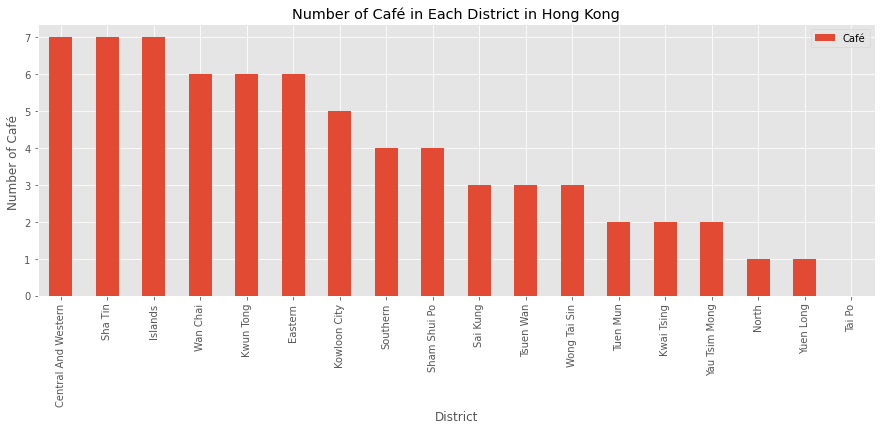

In [97]:
df_c.sort_values(by='Café', ascending=False, inplace=True)
df_c.plot(kind='bar', figsize=(15,5))

plt.title('Number of Café in Each District in Hong Kong')
plt.xlabel('District')
plt.ylabel('Number of Café ')

plt.show()

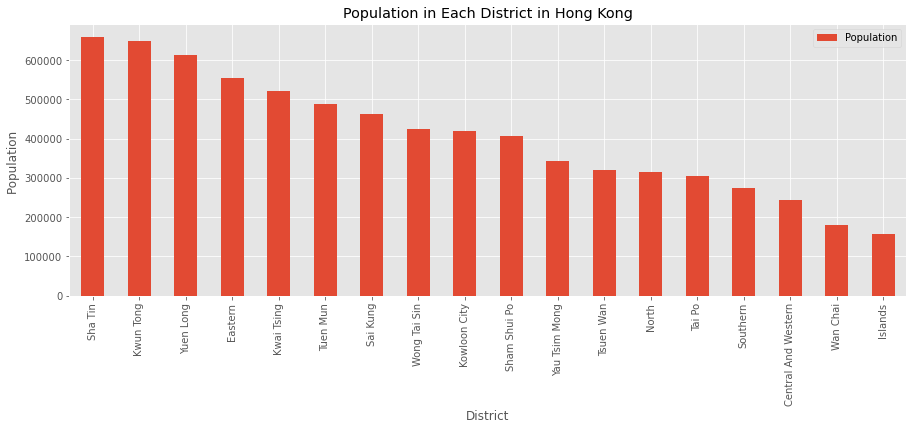

In [98]:
df_pop = df_all[['District','Population']].set_index('District')
df_pop.sort_values(by='Population', ascending=False, inplace=True)
df_pop.plot(kind='bar', figsize=(15,5))

plt.title('Population in Each District in Hong Kong')
plt.xlabel('District')
plt.ylabel('Population ')

plt.show()


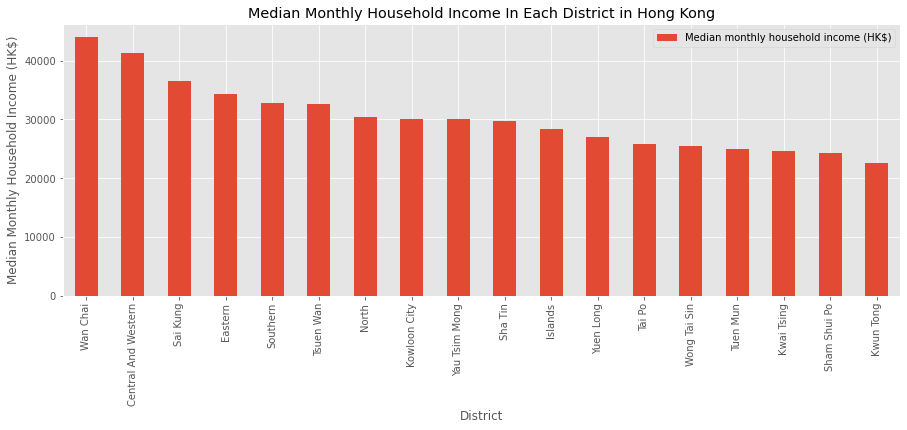

In [115]:
df_income = df_all[['District','Median monthly household income (HK$)']].set_index('District')
df_income.sort_values(by='Median monthly household income (HK$)', ascending=False, inplace=True)
df_income.plot(kind='bar', figsize=(15,5))

plt.title('Median Monthly Household Income In Each District in Hong Kong')
plt.xlabel('District')
plt.ylabel('Median Monthly Household Income (HK$)')

plt.show()


### Clustering The District

In [177]:
df_cl = pd.merge(df_all[['ObjectID','District','Population','Median monthly household income (HK$)']], df_c, on='District')
df_cl

,ObjectID,District,Population,Median monthly household income (HK$),Café
0,1,Central And Western,243266,41400,7
1,2,Eastern,555034,34300,6
2,3,Southern,274994,32800,4
3,4,Wan Chai,180123,44100,6
4,5,Sham Shui Po,405869,24300,4
5,6,Kowloon City,418732,30000,5
6,7,Kwun Tong,648541,22500,6
7,8,Wong Tai Sin,425235,25500,3
8,9,Yau Tsim Mong,342970,30000,2
9,10,Islands,156801,28400,7


In [178]:
from sklearn.cluster import KMeans 
from sklearn.datasets.samples_generator import make_blobs

# Setting the number of clusters
kclusters = 3
df_cl = df_cl.drop('District',1)

# Run k-means clustering algorithm
kmeans = KMeans(n_clusters=kclusters,random_state=0).fit(df_cl)

# Checking cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([1, 2, 1, 1, 0, 0, 2, 0, 1, 1], dtype=int32)

In [179]:
df_cl.insert(0, 'Cluster Label', kmeans.labels_)
df_cluster = pd.merge(df_all['District'], df_cl, left_index=True, right_index=True).set_index('ObjectID')
df_cluster

,District,Cluster Label,Population,Median monthly household income (HK$),Café
ObjectID,,,,,
1,Central And Western,1,243266,41400,7
2,Eastern,2,555034,34300,6
3,Southern,1,274994,32800,4
4,Wan Chai,1,180123,44100,6
5,Sham Shui Po,0,405869,24300,4
6,Kowloon City,0,418732,30000,5
7,Kwun Tong,2,648541,22500,6
8,Wong Tai Sin,0,425235,25500,3
9,Yau Tsim Mong,1,342970,30000,2


### Examine The Clusters

### Cluster 0

In [180]:
df_cluster.loc[df_cluster['Cluster Label'] == 0]

,District,Cluster Label,Population,Median monthly household income (HK$),Café
ObjectID,,,,,
5,Sham Shui Po,0,405869,24300,4
6,Kowloon City,0,418732,30000,5
8,Wong Tai Sin,0,425235,25500,3
11,Kwai Tsing,0,520572,24700,2
13,Sai Kung,0,461864,36500,3
17,Tuen Mun,0,489299,25000,2


### Cluster 1

In [181]:
df_cluster.loc[df_cluster['Cluster Label'] == 1]

,District,Cluster Label,Population,Median monthly household income (HK$),Café
ObjectID,,,,,
1,Central And Western,1,243266,41400,7
3,Southern,1,274994,32800,4
4,Wan Chai,1,180123,44100,6
9,Yau Tsim Mong,1,342970,30000,2
10,Islands,1,156801,28400,7
12,North,1,315270,30400,1
15,Tai Po,1,303926,25800,0
16,Tsuen Wan,1,318916,32600,3


### Cluster 2

In [182]:
df_cluster.loc[df_cluster['Cluster Label'] == 2]

,District,Cluster Label,Population,Median monthly household income (HK$),Café
ObjectID,,,,,
2,Eastern,2,555034,34300,6
7,Kwun Tong,2,648541,22500,6
14,Sha Tin,2,659794,29700,7
18,Yuen Long,2,614178,27000,1
